## Graph Neural Networks with Pytorch Geometric

Author: [Savannah Thais](https://github.com/savvy379)

First portion (Cora dataset) adapted from the [Pytorch Geometric Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html)

Introduction
This notebook teaches the reader how to build Graph Neural Networks (GNNs) with Pytorch Geometric (PyG). The first portion walks through a simple GNN architecture applied to the Cora Dataset; it is a modified version of the PyG [Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html) on node classifying GNNs. The second portion introduces a GNN-based charged particle tracking pipeline based on ["Charged particle tracking via edge-classifying interaction networks"](https://arxiv.org/abs/2103.16701).

A graph $G$ is a mathematical object consisting of a set of nodes (vertices) $N$ and edges $E$, $G=(N,E)$. Graphs can easily represent a wide range of structured data including atoms in molecules, users in a social network, cities and roads in a transportation system, players in team sports, objects interacting in a dynamical physical system, detector events , and more. The nodes and edges of the graph can have associated features as defined by the developer; these can include geometric information (ie particle hit locations in a detector) and non-geometric information (ie particle momenta). Graphs can be directed or undirected. A major advantage of GNNs is that they can handle input data of varying sizes: each graph processed by the network can have a different number of nodes and edges, making them well suited for a range of HEP applications as shown below for (a) particle tracking, (b) calorimeter clustering, (c) event classification, and (d) jet tagging (image from [Graph Neural Networks in Particle Physics](https://iopscience.iop.org/article/10.1088/2632-2153)).

![](https://drive.google.com/uc?id=1dGIKhsfeI7-Ik3pXL8t5Dsb6UyDohMiM)

In general, GNNs work by leveraging local information across the graph structure to intelligently re-embed the edges and nodes. A commonly used class of GNNs (and the focus of this tutorial) is the Graph Convolutional Network (GCN). GCNs use the same convolution operations as in a normal CNN, but apply the convolutions to node neighborhoods rather than a fixed data tensor (like an image matrix). These are considered a type of "Message Passing Network" when are 'message' is constructed by combining and transforming information from neighboring nodes and that message is 'passed' to a target node and used to update its features. In this way the entire graph can be transformed such that each node is updated to include additional useful information. The convolved graph is typically then processed by an additional linear layer that uses node and or edge features to do classification or regression on individual graph elements, graph substructures, or the graph as a whole. (Note: the same message passing structure can be applied to edges instead of nodes to update edge features as well). 

![](https://drive.google.com/uc?id=1f5MJO9Kw1tWjJMBJBsZ-M4tMFz_dydr2)

In mathematical terms, a single graph convolution layer can be described as: 

![](https://drive.google.com/uc?id=1hj82TSiKTwKTX9IFfpYRG7qygtSAAw6A)

Here, $h_v^0$ is the initial embedding of node $v$ (ie the original node features). To update the embedding of node $v$, $h_v^k$, the 'message' is constructed by applying a function $f$ to a the average over the current embedding of all the neighboring nodes (nodes connected to $v$ by a graph edge): $N(v)$) $\sum_{u \in N(v)}\frac{h_u^{k-1}}{deg(v)}$ and, optionally, the current embedding of the target node: $h_v^{k-1}$ then passed through a non-linear activation function and used to update the target node. In practice the functions $f$ is approximated by a matrix (convolution) $W_k$ with the added non-linearity of the activation function.   

This entire process is visualized in the below diagram, taken from the excellent paper [A Practical Guide to Graph Neural Networks](https://arxiv.org/abs/2010.05234).

![](https://drive.google.com/uc?id=1wKbb_pDP0pK8BFmA6Bxn4jvifs0nucd6)

# Coding!

## Part 1: Graph Node Classifaction with Cora

#### The Dataset

In the first part of this tutorial we will use the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA) to predict the subject of a research paper given its words and citation network. The cora dataset consists of 2,708 scientific papers with a unique id classified into one of 7 classes. The citation network consists of 5,429 links. Each paper has an associated binary word vector of size 1,433 indiating the presence of correpsonding word fromt he pre-defined dictionary. 

We'll start with some simple EDA to get familar with the dataset. In it's raw format, the dataset cnotains two tab-separated files: `cora.cites` and `cora.content`. The cites file includes all pairs of citation records formulated as two columns: `cited_paper_id` (target) and `citing_paper_id` (source). The content file includes the paper content recors with 1,435 columns: `paper_id`, `subject` (training target), and 1,433 binary features corresponding to the binary word vector. 

Let's go!

In [1]:
## mount your google drive so we can access the data from github. Skip this if running locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## skip this if running locally
%cd /content/drive/MyDrive/Github/codashep_ml_2022/lecture4_gnns/

/content/drive/MyDrive/Github/codashep_ml_2022/lecture4_gnns


In [3]:
## SETUP
# Install required packages.
import os
import torch
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf ## we're just using this for the EDA
from tensorflow import keras
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.12.0+cu113


In [ ]:
#download the raw data
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

180224/168052 [================================] - 0s 1us/step


To start our EDA we'll load the cites data into a dataframe and get the shape. We expect it to be 5429x2, representing 5429 linked paper pairs.

In [ ]:
#load the cites data into a dataframe and get the shape (expect it to be 5429x2, representing 5429 linked paper pairs)
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


We can also take a look at the beginning of the dataset

In [ ]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


The first few lines are listing the papers that reference paper ID 35.

Now we'll load the papers data and get the shape and take a look at the first few entries. We expect this df to be 2708x1435: 2708 unique papers and their associated topic and word binaries. 

In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [ ]:
print(papers.sample(5).T)

                      832         96                     2375  \
paper_id             66986     1110947                 632874   
term_0                   0           0                      0   
term_1                   0           1                      0   
term_2                   0           0                      0   
term_3                   0           0                      0   
...                    ...         ...                    ...   
term_1429                0           0                      0   
term_1430                0           0                      0   
term_1431                0           0                      0   
term_1432                0           0                      0   
subject    Neural_Networks  Case_Based  Probabilistic_Methods   

                      527                    2384  
paper_id            120084                 180301  
term_0                   0                      0  
term_1                   0                      0  
term_2     

We can also look at the count of papers in each subject:

In [ ]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


We can use the `networkx` package to visualize a subset of the papers in the citation graph format. Each node will represent an idividual paper, nodes will be connected by an edge if one paper cites the other, and the color of each node will represent subject area.

First we'll do a little transformatio on the dataset to make it easier to plot. We'll convert the paper ids and subjects into zero-based indices. The papers will be indexed starting from 0 and the paper subjects will be represented by a value between 0 and 7, correpsonding to the subject classes.

In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

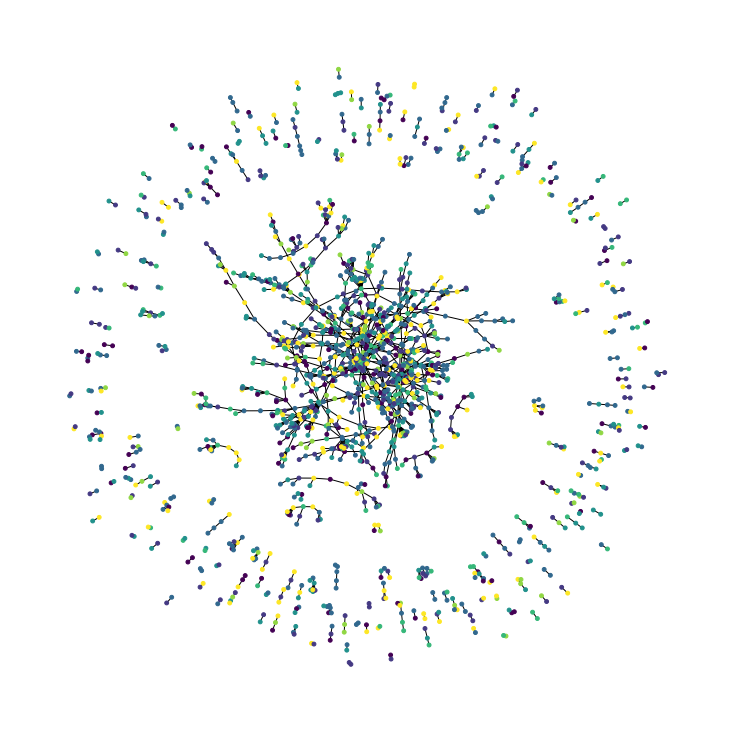

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

We can see many small citation clusters on the outside of the graph consisting of a few papers typically all in one or two subjects, and a large, interconnected subgraph in the center where many different papers are connected through a citation chain. Let's see if we can use this graph to learn to predict the subject area of different papers! 

### Building a GNN 
First, we'll re-download the Cora dataset in a PyG friendly format

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


We can easily get some summary information about the dataset

In [ ]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


We see it is identical to the raw txt file format: 2708 nodes (papers), 10556 edges (5278 citation pairs*), 1433 node features (word embedings), and 1 node label (paper subject). The dataset provides `val` and `test` masks to create subsets of nodes to act as training and validation datasets. For training, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of 5%.

**Note:** The graph construction used in this version of the dataset is actually slightly different than the raw data (originally 5429 citation pairs). Here they form an undirected graph, ie they create two edges between each citation pair, removing allowing information to flow both ways but eliminating information about which paper cites which (directed edges). 

We can construct a GNN in PyG very similary to how we build a standard feed-forward neural network. We just need to swap the `torch.nn.Linear` layers with PyG's GNN operators. 

In particular, we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information. The construction of the local neighborhood is handled by the `GCNConv` layer definition within PyG.

Let's set up our model!


In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

## just like with regular NNs in Pytorch we need to define the layer structure of our GNN and the forward propagation of the network 
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        ## our GNN will have two graph convolution layers, one that re-embeds each node into the number of hidden channels, and one that
        ## predicts the class label (by re-embedding each node into 7 dimensions)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane. Each node is colored according to its true subject label.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


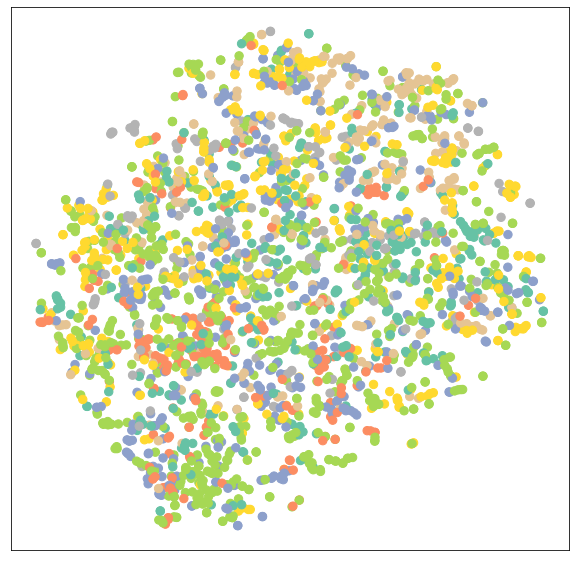

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Now we can train our model! Again, the process is very similar to training a standard NN, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


And we can check the test set accuracy

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


Not perfect, but it's pretty accurate at predicting paper subject area!

We can further verify that  by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


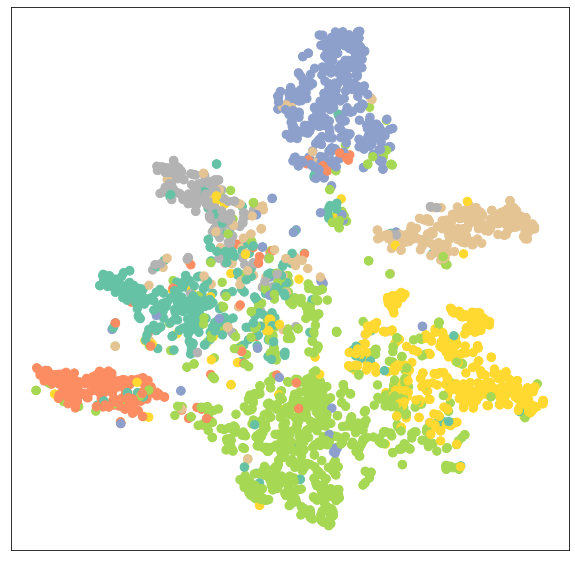

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Wrap Up
Nice! We've used PyG to build an effective GNN that re-embeds the initial Cora dataset graph into a space more useful for node label prediction. This is a just one of the many available GNN architectures and only one of the possible graph prediction tasks; other common tasks include edge classification (coming up next!) and graph classification (check out this [tutorial]( https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing)), among others. 

### (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

3. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

## Part Two: Edge Classification for Charged Particle Tracking

### Introduction

Now we'll turn to an actual physics example! We'll be using GNNs for charged particle tracking. This tutorial is based on the paper ["Charged particle tracking via edge-classifying interaction networks"](https://arxiv.org/abs/2103.16701) by DeZoort et al, however there is much excellent work exploring GNNs for tracking (see also [ExaTrkX](https://exatrkx.github.io/)) and other reconstruction and analysis tasks in HEP (see the recent paper ["Graph Neural Networks in Particle Physics: Implementations, Innovations, and Challenges"](https://arxiv.org/abs/2203.12852)). 

Charged particle tracking can be thought of as the problem of 'connecting the dots' where the 'dots' are hits in the tracker of a particle detector. The goal is to identify which hits belong to an individual particle trajectory, group them together, and fit the path to extract particle kinematics like momentum. 

![](https://drive.google.com/uc?id=13JSzVGs4YJxV6DSlSXT7ZayT5oQZevkq)

This task can be represented naturally as a graph-based problem. Beginning with a point cloud of tracker hits, one can construct a graph by building edges (potential track segments) between the hits, process the graph with an edge-classifying GNN to identify if an edge is a true track segment or a noise edge, and then link the positively identified edges together to form track candidates (that would then be fit). 

![](https://drive.google.com/uc?id=1eHLlvmCCs0rz2YGcq4ZSncRB1TizQTFG)



### Dataset
For this tutorial we will be using a subset of the [TrackML Challenge](https://www.kaggle.com/competitions/trackml-particle-identification/overview) dataset. The dataset consists of multiple simulated, independent ttbar events measured by a generic detector similar to ATLAS and CMS. 

![](https://drive.google.com/uc?id=1o3UWM1auvhKtwnMnroAhc__4_PeSUTgR)

In `rz` coordinates (ie in the diagram above), particle tracks will look like the center example below. 

![](https://drive.google.com/uc?id=1w9Og0ec2_BvXZQo1vxlPK9g-PDbIXQ4y)

Each event in the TrackML dataset has four associated files that contain hits, hit cells, particles, and the ground truth association between them. 

**Event hits**

The hits file contains the following values for each hit/entry in the event:

- hit_id: numerical identifier of the hit inside the event.
- x, y, z: measured x, y, z position (in millimeter) of the hit in global coordinates.
- volume_id: numerical identifier of the detector group.
- layer_id: numerical identifier of the detector layer inside the group.
- module_id: numerical identifier of the detector module inside the layer.

**Event truth**

The truth file contains the mapping between hits and generating particles and the true particle state at each measured hit. Each entry maps one hit to one particle.

- hit_id: numerical identifier of the hit as defined in the hits file.
- particle_id: numerical identifier of the generating particle as defined in the particles file. A value of 0 means that the hit did not originate from a reconstructible particle, but e.g. from detector noise.
- tx, ty, tz: true intersection point in global coordinates (in millimeters) between the particle trajectory and the sensitive surface.
- tpx, tpy, tpz: true particle momentum (in GeV/c) in the global coordinate system at the intersection point. The corresponding vector is tangent to the particle trajectory at the intersection point.
- weight per-hit: weight used for the scoring metric; total sum of weights within one event equals to one.

**Event particles**

The particles files contains the following values for each particle/entry (this is truth/generator infomation):

- particle_id: numerical identifier of the particle inside the event.
- vx, vy, vz: initial position or vertex (in millimeters) in global coordinates.
- px, py, pz: initial momentum (in GeV/c) along each global axis.
- q: particle charge (as multiple of the absolute electron charge).
- nhits: number of hits generated by this particle.

**Event hit cells**

The cells file contains the constituent active detector cells that comprise each hit. We won't be using this information in our example. 


Let's take a look at one TrackML event to familiarize ourselves.

In [21]:
particles=pd.read_csv('trackml/event000000200-particles.csv')
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.024934,-0.014566,-11.263,-0.055269,0.323272,-0.203492,-1,3
1,4503737066323968,-0.024934,-0.014566,-11.263,-0.948125,0.470892,2.010060,1,10
2,4503805785800704,-0.024934,-0.014566,-11.263,-0.886484,0.105749,0.683881,-1,10
3,4503874505277440,-0.024934,-0.014566,-11.263,0.257539,-0.676718,0.991616,1,11
4,4503943224754176,-0.024934,-0.014566,-11.263,16.439400,-15.548900,-39.824900,1,11


In [22]:
truth=pd.read_csv('trackml/event000000200-truth.csv')
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,328762978956476416,-62.6615,-3.048720,-1502.5,-1.025760,-0.032316,-24.53690,0.000014
1,2,108090582944972800,-66.1239,-1.376350,-1502.5,-0.634752,0.007755,-14.21880,0.000008
2,3,72094565116411904,-63.6906,1.726280,-1502.5,-0.826153,0.040302,-19.25260,0.000013
3,4,238697583478833152,-82.5072,-14.093000,-1502.5,-0.244242,-0.062864,-4.57011,0.000006
4,5,0,-74.3428,0.844152,-1502.5,-166440.000000,2483.800000,-986048.00000,0.000000


In [23]:
hits=pd.read_csv('trackml/event000000200-hits.csv')
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-62.6632,-3.05090,-1502.5,7,2,1
1,2,-66.1247,-1.36730,-1502.5,7,2,1
2,3,-63.6977,1.73267,-1502.5,7,2,1
3,4,-82.5018,-14.09150,-1502.5,7,2,1
4,5,-74.3434,0.84469,-1502.5,7,2,1


### Graph Construction
In many GNN applications, especially in HEP, graph construction is one of the more challenging portions of developing a GNN pipeline. Graph edges are what allows information to flow through the graph and inform the new graph embeddings, and thus the formation of graph edges can have a large impact of the performance of the GNN. Particle tracking events are quite large, and thus the naive approach of forming a fully connected graph is not computationally feasible and we must develop a smart, physics-informed graph construction method. 

In our graph construction approach we apply first a set of truth filters are applied to hits before they are assigned to graph nodes. $p_T$  filters reject hits generated by particles with $p_T < p_{T_{min}}$, noise filters reject noise hits, and same-layer filters reject all but one hit per layer for each particle. These truth filters are used to modulate the number of hits present in each hit graph to make it more feasible to apply GNN methods and can be thought of as an idealized hit filtering step. Additionally, to reduce the size of the graphs and provide a feasible tutorial, we focus only on the inner-tracker (pixel) portion of the detector (modules 7, 8, and 9).

The same-layer filter introduces an ambiguity in defining edges between the barrel and innermost endcap layers. Specifically, barrel hits generated by the same particle could produce multiple true edges incoming to a single endcap hit. The resulting triangular edge pattern conflicts with the main assumption of the same-layer filter, that only one true track segment exists between each subsequent layer. For this reason, a barrel intersection cut was developed, in which edges between a barrel layer and an innermost endcap layer are rejected if they intersect with any intermediate barrel layers. 

![](https://drive.google.com/uc?id=1z85fJTGi8gQUSwCx5fia6nAK9o2cbvRN)

In addition to the barrel intersection cut, edges must also satisfy ${T_{min}}$-dependent constraints on the geometric quantities $z_0=z_i - r_i \frac{z_j-z_i}{r_j-r_i}$ and $\phi_{slope}=\frac{\phi_j-\phi_i}{r_j-r_i}$.

Ok, let's start writing the code to do this! Warning, it's going to be a bit dense, but let's jump in! 

In [4]:
## we need to install the trackml library for easy data handling.
## if working locally you can install this locally
!git clone https://github.com/LAL/trackml-library.git

fatal: destination path 'trackml-library' already exists and is not an empty directory.


In [5]:
## skip this if running locally
!pip install trackml-library/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./trackml-library
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for trackml: filename=trackml-3-py2.py3-none-any.whl size=13527 sha256=40616d656ab1c0c8ad36bcba120810f275cd5524f2452c1f51fe52c1c41e0192
  Stored in directory: /root/.cache/pip/wheels/04/a0/ab/63122e367b09ee77f10270e948b0af7620bed90b09f06a7932
Successfully built trackml
  Attempting uninstall: trackml
    Found existing installation: trackml 3
    Uninstalling trackml-3:
      Successfully uninstalled trackml-3


In [7]:
## import additional libraries we'll need for tracker graph building

## system
import logging
import multiprocessing as mp
from functools import partial
from collections import Counter

## external
import yaml
import pickle
import trackml.dataset
import time
from torch_geometric.data import Data

First we'll define helper functions to calculate the edge features.

In [8]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def calc_eta(r, z):
    """Computes pseudorapidity
       (https://en.wikipedia.org/wiki/Pseudorapidity)
    """
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

First, let's write a function to **select the hits** we want to include in our graph. This function specifies which detector modules we want to consider (pixel detector) gets the particle truth information and merges it with the individual hits, re-indexes the layer ids to start from 0 and the particle ids to run from 1 to n_particles and and applies the $p_T$, noise removal, and multiple hits per layer filters. It returns a list of accepted hits and a list of accepted particle ids. 

In [9]:
def select_hits(hits, truth, particles, pt_min=0, endcaps=False, 
                remove_noise=False, remove_duplicates=False):
     
    # Barrel volume and layer ids
    vlids = [(8,2), # 0 
             (8,4), # 1
             (8,6), # 2
             (8,8)] # 3
    if (endcaps): 
        vlids.extend([(7,14), # 4 
                      (7,12), # 5
                      (7,10), # 6
                      (7,8),  # 7
                      (7,6),  # 8
                      (7,4),  # 9
                      (7,2),  # 10
                      (9,2),  # 11
                      (9,4),  # 12
                      (9,6),  # 13
                      (9,8),  # 14
                      (9,10), # 15
                      (9,12), # 16
                      (9,14), # 17
                     ])
    n_det_layers = len(vlids)
    
    # Select barrel layers and assign convenient layer number [0-9]
    vlid_groups = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])
    
    # Calculate particle transverse momentum
    particles['pt'] = np.sqrt(particles.px**2 + particles.py**2)
    particles['eta_pt'] = calc_eta(particles.pt, particles.pz)
    
    # True particle selection.
    particles = particles[particles.pt > pt_min]
    truth_noise = truth[['hit_id', 'particle_id']][truth.particle_id==0]
    truth_noise['pt'] = 0
    truth = (truth[['hit_id', 'particle_id']]
             .merge(particles[['particle_id', 'pt', 'eta_pt']], on='particle_id'))

    # optionally add noise 
    if (not remove_noise): 
        truth = truth.append(truth_noise)

    # calculate derived hits variables
    hits['r'] = np.sqrt(hits.x**2 + hits.y**2)
    hits['phi'] = np.arctan2(hits.y, hits.x)
    hits['eta'] = calc_eta(hits.r, hits.z)
    
    # select the data columns we need
    hits = (hits[['hit_id', 'r', 'phi', 'eta', 'z', 'layer', 'module_id']]
            .merge(truth[['hit_id', 'particle_id', 'pt', 'eta_pt']], on='hit_id'))
    
    # optionally remove duplicates
    if (remove_duplicates):
        noise_hits = hits[hits.particle_id==0]
        particle_hits = hits[hits.particle_id!=0]
        particle_hits = particle_hits.loc[particle_hits.groupby(['particle_id', 'layer']).r.idxmin()]
        hits = particle_hits.append(noise_hits)
        
    # relabel particle IDs in [1:n_particles]
    particles = particles[particles.particle_id.isin(pd.unique(hits.particle_id))]
    particle_id_map = {p: i+1 for i, p in enumerate(particles['particle_id'].values)}
    particle_id_map[0] = 0
    particles = particles.assign(particle_id=particles['particle_id'].map(particle_id_map))
    hits = hits.assign(particle_id=hits['particle_id'].map(particle_id_map))
    return hits, particles

Now we write a function to form the **allowed graph edges**. We'll look at all possible pairs of hits, calculate the geometric features of the edges between them, apply our geometric cuts and the intersecting line cut, and create a matrix of selected edges that contains:
- the hit ids of the two hits the edge connects (as a tuple)
- the geometric features of the edge (dr, dR, dphi, and dz)

In [10]:
def select_edges(hits1, hits2, layer1, layer2, 
                 phi_slope_max, z0_max):

    # start with all possible pairs of hits
    keys = ['evtid', 'r', 'phi', 'z', 'module_id']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))

    # compute geometric features of the line through each hit pair
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    eta_1 = calc_eta(hit_pairs.r_1, hit_pairs.z_1)
    eta_2 = calc_eta(hit_pairs.r_2, hit_pairs.z_2)
    deta = eta_2 - eta_1
    dR = np.sqrt(deta**2 + dphi**2)
    
    # phi_slope and z0 used to filter spurious edges
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    
    # apply the intersecting line cut 
    intersected_layer = dr.abs() < -1 
    # 0th barrel layer to left EC or right EC
    if (layer1 == 0) and (layer2 == 11 or layer2 == 4): 
        z_coord = 71.56298065185547 * dz/dr + z0
        intersected_layer = np.logical_and(z_coord > -490.975, 
                                           z_coord < 490.975)
    # 1st barrel layer to the left EC or right EC
    if (layer1 == 1) and (layer2 == 11 or layer2 == 4): 
        z_coord = 115.37811279296875 * dz / dr + z0
        intersected_layer = np.logical_and(z_coord > -490.975, 
                                           z_coord < 490.975)

    # filter edges according to selection criteria
    good_edge_mask = ((phi_slope.abs() < phi_slope_max) & # geometric
                      (z0.abs() < z0_max) &               # geometric
                      (intersected_layer == False)) #&      # geometric
    
    # store edges (in COO format) and geometric edge features 
    selected_edges = {'edges': hit_pairs[['index_1', 'index_2']][good_edge_mask],
                      'dr': dr[good_edge_mask],    
                      'dphi': dphi[good_edge_mask], 
                      'dz': dz[good_edge_mask],
                      'dR': dR[good_edge_mask]}
    
    return selected_edges 

We then use those functions to write a function that **constructs the graphs** by forming the possible pairs of hits between adjacent layers of the detector, creating edges, applying the edge selection function, identifying if edges are true by checking the pid of the hits at either end, and saving everything into a graph structure consisting of several distinct matrices:
- x: the node (hit) features (position)
- hit_id: to track the hit id 
- edge_index: to track the edge id
- edge_attr: the geometric edge features
- y: the edge truth label (1 or 0)
- s: the detector segments (we won't be using this for now)

In [11]:
def construct_graph(hits, layer_pairs, phi_slope_max, z0_max,
                    feature_names, feature_scale, evtid="-1",
                    s=(-1,-1)):
    """ Loops over hits in layer pairs and extends edges
        between them based on geometric and/or data-driven
        constraints. 
    """
    # loop over layer pairs, assign edges between their hits
    groups = hits.groupby('layer')
    edges, dr, dphi, dz, dR = [], [], [], [], []
    for (layer1, layer2) in layer_pairs:
        try:
            hits1 = groups.get_group(layer1)
            hits2 = groups.get_group(layer2)
        except KeyError as e: # skip if layer is empty
            continue
            
        # assign edges based on geometric and data-driven constraints
        selected_edges = select_edges(hits1, hits2, layer1, layer2,
                                      phi_slope_max, z0_max)  # geometric 
        edges.append(selected_edges['edges'])
        dr.append(selected_edges['dr'])
        dphi.append(selected_edges['dphi'])
        dz.append(selected_edges['dz'])
        dR.append(selected_edges['dR'])
    
    # if edges were reconstructed, concatenate edge 
    # attributes and indices across all layer pairs 
    if len(edges) > 0:
        edges = pd.concat(edges)
        dr, dphi = pd.concat(dr), pd.concat(dphi)
        dz, dR = pd.concat(dz), pd.concat(dR)
    else: # if no edges were reconstructed, return empty graph 
        edges = np.array([])
        dr, dphi = np.array([]), np.array([])
        dz, dR = np.array([]), np.array([])
        x = (hits[feature_names].values / feature_scale).astype(np.float32)
        return {'x': x, 'hit_id': hits['hit_id'],
                'edge_index': np.array([[],[]]),
                'edge_attr': np.array([[],[],[],[]]),
                'y': [], 's': s}
    
    # prepare the graph matrices
    n_nodes = hits.shape[0]
    n_edges = edges.shape[0]
    
    # select and scale relevant features
    x = (hits[feature_names].values / feature_scale).astype(np.float32)
    edge_attr = np.stack((dr/feature_scale[0], 
                          dphi/feature_scale[1], 
                          dz/feature_scale[2], 
                          dR))
    y = np.zeros(n_edges, dtype=np.float32)

    # use a series to map hit label-index onto positional-index.
    node_idx = pd.Series(np.arange(n_nodes), index=hits.index)
    edge_start = node_idx.loc[edges.index_1].values
    edge_end = node_idx.loc[edges.index_2].values
    edge_index = np.stack((edge_start, edge_end))

    # fill the edge, particle labels
    # true edges have the same pid, ignore noise (pid=0)
    pid1 = hits.particle_id.loc[edges.index_1].values
    pid2 = hits.particle_id.loc[edges.index_2].values
    y[:] = ((pid1 == pid2) & (pid1>0) & (pid2>0)) 
    
    return {'x': x, 'hit_id': hits['hit_id'],
            'edge_index': edge_index, 'edge_attr': edge_attr, 
            'y': y, 's': s}

Now we'll define some helper functions that will help us measure how good our graph construction is. We want to consider two measurements of graph construction: graph construction efficiency ($N_{reconstructed}^{true}/N_{possible}^{true}$) and purity ($N_{reconstructed}^{true} /N_{reconstructed}^{total}$). In general, we want both of these numbers to be as high as possible, however there is typically a tradeoff between efficiency and purity. 


In [12]:
def get_particle_properties(hits_by_particle, valid_connections, debug=False):
    """ Calculates the following truth quantities per particle:
         - n_track_segs: number of track segments generated
         - reconstructable: true if particle doesn't skip a layer
         - pt: particle transverse momentum [GeV]
         - eta: pseudorapidity w.r.t. transverse and longitudinal momentum
    """
    # loop over particle_ids and corresponding particle hits
    n_track_segs, reconstructable = {}, {}
    pt, eta = {}, {}
    for particle_id, particle_hits in hits_by_particle:
        
        # noise isn't reconstructable, store 0s
        if (particle_id==0): 
            reconstructable[particle_id] = 0
            pt[particle_id] = 0
            eta[particle_id] = 0
            n_track_segs[particle_id] = 0
            continue
            
        # store pt and eta 
        pt[particle_id] = particle_hits.pt.values[0]
        eta[particle_id] = particle_hits.eta_pt.values[0]
        
        # store hit multiplicity per layer 
        layers_hit = particle_hits.layer.values
        hits_per_layer = Counter(layers_hit) 
        layers = np.unique(layers_hit)
        
        # single-hits aren't reconstructable
        if (len(layers)==1): 
            reconstructable[particle_id] = 0
            n_track_segs[particle_id] = 0
            continue
        
        # all edges must be valid for a reconstructable particle
        layer_pairs = set(zip(layers[:-1], layers[1:]))
        reconstructable[particle_id] = layer_pairs.issubset(valid_connections)
        
        # total number of track segments produced by particle 
        good_layer_pairs = layer_pairs.intersection(valid_connections)
        count = 0
        for good_lp in good_layer_pairs:
            count += hits_per_layer[good_lp[0]] * hits_per_layer[good_lp[1]]
        n_track_segs[particle_id] = count
        
        if debug and (particle_id%100==0):
            print('Test Hit Pattern:', layers_hit)
            print(' - layer pairs:', layer_pairs)
            print(' - reconstructable:', reconstructable[particle_id])
            print(' - n_track_segs:', n_track_segs[particle_id])
            print(' - pt', pt[particle_id])
            print(' - eta', eta[particle_id])
        
    return {'pt': pt, 'eta': eta, 'n_track_segs': n_track_segs, 
            'reconstructable': reconstructable}

In [13]:
def get_n_track_segs(hits_by_particle, valid_connections):
    """ Calculates the number of track segments present in 
        a subset of hits generated by a particle
        (used for analyzing efficiency per sector)
    """
    # loop over particle_ids and corresponding particle hits
    n_track_segs = {}
    for particle_id, particle_hits in hits_by_particle:
        
        # noise doesn't produce true edges
        if (particle_id==0): 
            n_track_segs[particle_id] = 0
            continue
            
        # store hit multiplicity per layer 
        layers_hit = particle_hits.layer.values
        hits_per_layer = Counter(layers_hit) 
        layers = np.unique(layers_hit)
        
        # single-hits don't produce truth edges
        if (len(layers)==1): 
            n_track_segs[particle_id] = 0
            continue
        
        # all edges must be valid for a reconstructable particle
        layer_pairs = set(zip(layers[:-1], layers[1:]))
        
        # total number of true edges produced by particle 
        good_layer_pairs = layer_pairs.intersection(valid_connections)
        count = 0
        for good_lp in good_layer_pairs:
            count += hits_per_layer[good_lp[0]] * hits_per_layer[good_lp[1]]
        n_track_segs[particle_id] = count
        
    return n_track_segs

We'll define a function to split the detector into segments in case we want to create smaller graphs from eta-phi slices of the detector. We won't use this for now but you can play around with it later. 

In [14]:
def split_detector_sectors(hits, phi_edges, eta_edges, verbose=False):
    """Split hits according to provided phi and eta boundaries."""
    hits_sectors = {}
    sector_info = {}
    phi_overlap, eta_overlap = 0, 0
    for i in range(len(phi_edges) - 1):
        phi_min, phi_max = phi_edges[i], phi_edges[i+1]
        # Select hits in this phi sector
        phi_hits = hits[((hits.phi > (phi_min-phi_overlap)) & 
                          (hits.phi < (phi_max+phi_overlap)))]
        # Center these hits on phi=0
        centered_phi = phi_hits.phi - (phi_min + phi_max) / 2
        phi_hits = phi_hits.assign(phi=centered_phi, phi_sector=i)
        for j in range(len(eta_edges) - 1):
            eta_min, eta_max = eta_edges[j], eta_edges[j+1]
            # Select hits in this eta sector
            eta = calc_eta(phi_hits.r, phi_hits.z)
            sec_hits = phi_hits[((eta > (eta_min-eta_overlap)) & 
                                 (eta < (eta_max+eta_overlap)))]
            
            # label hits by tuple s = (eta_sector, phi_sector)
            hits_sectors[(j,i)] = sec_hits.assign(eta_sector=j)
                         
            # store eta and phi ranges per sector
            sector_info[(j,i)] = {'eta_range': [eta_min, eta_max],
                                  'phi_range': [phi_min, phi_max]}
            if verbose:
                logging.info(f"Sector ({i},{j}):\n" + 
                             f"...eta_range=({eta_min:.3f},{eta_max:.3f})\n"
                             f"...phi_range=({phi_min:.3f},{phi_max:.3f})")
    
    return hits_sectors, sector_info

Alright, now we can write our **graph summary** function that uses these helpers to calculate quantitative features about the graph: 
- total_track_segs: # track segments (true edges) possible 
         - total_nodes: # nodes present in graph / sector
         - total_edges: # edges present in graph / sector
         - total_true: # true edges present in graph / sector
         - total_false # false edges present in graph / sector
         - boundary_fraction: fraction of track segs lost between sectors

In [15]:
def graph_summary(evtid, sectors, particle_properties, 
                  sector_info, print_per_layer=False):
    """ Calculates per-sector and per-graph summary stats
        and returns a dictionary for subsequent analysis
         - total_track_segs: # track segments (true edges) possible 
         - total_nodes: # nodes present in graph / sector
         - total_edges: # edges present in graph / sector
         - total_true: # true edges present in graph / sector
         - total_false # false edges present in graph / sector
         - boundary_fraction: fraction of track segs lost between sectors
         
    """
   
    # truth number of track segments possible
    track_segs = particle_properties['n_track_segs'].values()
    total_track_segs = np.sum(list(track_segs))
    total_track_segs_sectored = 0
    
    # reconstructed quantities per graph
    total_nodes, total_edges = 0, 0
    total_true, total_false = 0, 0

    # helper function for division by 0
    def div(a,b):
        return float(a)/b if b else 0
    
    # loop over graph sectors and compile statistics
    sector_stats = {}
    total_possible_per_s = 0
    for i, sector in enumerate(sectors):
        
        # get information about the graph's sector
        s = sector['s'] # s = sector label
        sector_ranges = sector_info[s]
        
        # calculate graph properties
        n_nodes = sector['x'].shape[0]
        total_nodes += n_nodes 
        n_true = np.sum(sector['y'])
        total_true += n_true
        n_false = np.sum(sector['y']==0)
        total_false += n_false
        n_edges = len(sector['y'])
        total_edges += n_edges
        
        # calculate track segments in sector
        n_track_segs_per_pid = particle_properties['n_track_segs_per_s'][s]
        n_track_segs = np.sum(list(n_track_segs_per_pid.values()))
        total_track_segs_sectored += n_track_segs
        
        # estimate purity in each sector
        sector_stats[i] = {'eta_range': sector_ranges['eta_range'],
                           'phi_range': sector_ranges['phi_range'],
                           'n_nodes': n_nodes, 'n_edges': n_edges,
                           'purity': div(n_true, n_edges),
                           'efficiency': div(n_true, n_track_segs)}
        
    # proportion of true edges to all possible track segments
    efficiency = div(total_true, total_track_segs)
    # proportion of true edges to total reconstructed edges
    purity = div(total_true, total_edges)
    # proportion of true track segments lost in sector boundaries
    boundary_fraction = div(total_track_segs - total_track_segs_sectored, 
                            total_track_segs)
    
    logging.info(f'Event {evtid}, graph summary statistics\n' + 
                 f'...total nodes: {total_nodes}\n' +
                 f'...total edges: {total_edges}\n' + 
                 f'...efficiency: {efficiency:.5f}\n' +
                 f'...purity: {purity:.5f}\n'
                 f'...boundary edge fraction: {boundary_fraction:.5f}')

    return {'n_nodes': total_nodes, 'n_edges': total_edges,
            'efficiency': efficiency, 'purity': purity,
            'boundary_fraction': boundary_fraction,
            'sector_stats': sector_stats}

We're almost there! Now we'll write a function to take all of our previoiusly defined functions and process our input TrackML events. It defines which layer pairs are allowed (adjacent layers), loads the data, and calls all our functions in order: hit selection, truth info calculation, detector segmentation, and graph construction.

In [18]:
def process_event(prefix, output_dir, pt_min, 
                  n_eta_sectors, n_phi_sectors,
                  eta_range, phi_range, phi_slope_max, z0_max,
                  endcaps, remove_noise, remove_duplicates):
    
    # define valid layer pair connections
    layer_pairs = [(0,1), (1,2), (2,3)] # barrel-barrel
    if endcaps:
        layer_pairs.extend([(0,4), (1,4), (2,4),  # barrel-LEC
                            (0,11), (1,11), (2,11), # barrel-REC
                            (4,5), (5,6), (6,7), # LEC-LEC
                            (7,8), (8,9), (9,10), 
                            (11,12), (12,13), (13,14), # REC-REC
                            (14,15), (15,16), (16,17)])
                                 
    # load the data
    evtid = int(prefix[-9:])
    logging.info('Event %i, loading data' % evtid)
    hits, particles, truth = trackml.dataset.load_event(
        prefix, parts=['hits', 'particles', 'truth'])

    # apply hit selection
    logging.info('Event %i, selecting hits' % evtid)
    hits, particles = select_hits(hits, truth, particles, pt_min, endcaps, 
                                  remove_noise, remove_duplicates)
    hits = hits.assign(evtid=evtid)
    
    # get truth information for each particle
    hits_by_particle = hits.groupby('particle_id')
    particle_properties = get_particle_properties(hits_by_particle,
                                                  set(layer_pairs), debug=False)
    hits = hits[['hit_id', 'r', 'phi', 'eta', 'z', 'evtid',
                 'layer', 'module_id', 'particle_id']]
    
    # divide detector into sectors
    phi_edges = np.linspace(*phi_range, num=n_phi_sectors+1)
    eta_edges = np.linspace(*eta_range, num=n_eta_sectors+1)
    hits_sectors, sector_info = split_detector_sectors(hits, phi_edges, eta_edges)

    # calculate particle truth in each sector
    n_track_segs_per_s = {}
    for s, hits_sector in hits_sectors.items():
        hits_sector_by_particle = hits_sector.groupby('particle_id')
        n_track_segs_s = get_n_track_segs(hits_sector_by_particle, set(layer_pairs))
        n_track_segs_per_s[s] = n_track_segs_s
    particle_properties['n_track_segs_per_s'] = n_track_segs_per_s
    
    # graph features and scale
    feature_names = ['r', 'phi', 'z']
    feature_scale = np.array([1000., np.pi / n_phi_sectors, 1000.])

    # Construct the graph
    logging.info('Event %i, constructing graphs' % evtid)
    sectors = [construct_graph(sector_hits, layer_pairs=layer_pairs,
                               phi_slope_max=phi_slope_max, z0_max=z0_max,
                               s=s, feature_names=feature_names,
                               feature_scale=feature_scale,
                               evtid=evtid)
               for s, sector_hits in hits_sectors.items()]

    logging.info('Event %i, calculating graph summary' % evtid)
    summary_stats = graph_summary(evtid, sectors, particle_properties,
                                  sector_info, print_per_layer=False)
    
    output = {'sectors': sectors, 
              'particle_properties': particle_properties,
              'summary_stats': summary_stats}
    
    return output

Alright, we're finally ready to build some graphs!! We'll apply a relatively high $p_T$ cut of 2 GeV to keep the graphs small and the code running quickly. We also won't segment the detector right now. 

In [22]:
input_dir = 'trackml'
output_dir = 'graphs'
n_files = 2
verbose = False
task = 0
n_tasks = 1
n_workers = 10

## specify our geometric requirements
config = {'pt_min': 2, # GeV,
          'phi_slope_max': 0.0006,
          'z0_max': 15000,
          'n_phi_sectors': 1,
          'n_eta_sectors': 1,
          'eta_range': [-5, 5],
          'endcaps': True,
          'remove_noise': True, 
          'remove_duplicates': True,
         }

# Setup logging
log_format = '%(asctime)s %(levelname)s %(message)s'
log_level = logging.DEBUG if verbose else logging.INFO
logging.basicConfig(level=log_level, format=log_format)
logging.info('Initializing')

# Find the input files
all_files = os.listdir(input_dir)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))
file_prefixes = file_prefixes[:n_files]
evtids = [int(prefix[-9:]) for prefix in file_prefixes]

# Split the input files by number of tasks and select my chunk only
file_prefixes = np.array_split(file_prefixes, n_tasks)[task]

with mp.Pool(processes=n_workers) as pool:
    process_func = partial(process_event, output_dir=output_dir,
                           phi_range=(-np.pi, np.pi),
                           **config)
    output = pool.map(process_func, file_prefixes)

# analyze output statistics
logging.info('All done!')
graph_sectors = [graph['sectors'] for graph in output]
output = [graph['summary_stats'] for graph in output]
n_nodes = np.array([graph_stats['n_nodes'] for graph_stats in output])
n_edges = np.array([graph_stats['n_edges'] for graph_stats in output])
purity = np.array([graph_stats['purity'] for graph_stats in output])
efficiency = np.array([graph_stats['efficiency'] for graph_stats in output])
boundary_fraction = np.array([graph_stats['boundary_fraction'] for graph_stats in output])
logging.info(logging.info(f'Events average stats:\n' +
                          f'...n_nodes: {n_nodes.mean():.0f}+/-{n_nodes.std():.0f}\n' +
                          f'...n_edges: {n_edges.mean():.0f}+/-{n_edges.std():.0f}\n' + 
                          f'...purity: {purity.mean():.5f}+/-{purity.std():.5f}\n' + 
                          f'...efficiency: {efficiency.mean():.5f}+/-{efficiency.std():.5f}\n' + 
                          f'...boundary fraction: {boundary_fraction.mean():.5f}+/-{boundary_fraction.std():.5f}'))

2022-07-21 13:18:07,003 INFO Initializing
2022-07-21 13:18:07,293 INFO Event 201, loading data
2022-07-21 13:18:07,293 INFO Event 200, loading data
2022-07-21 13:18:07,953 INFO Event 200, selecting hits
2022-07-21 13:18:08,028 INFO Event 201, selecting hits
2022-07-21 13:18:09,221 INFO Event 200, constructing graphs
2022-07-21 13:18:09,489 INFO Event 201, constructing graphs
2022-07-21 13:18:10,112 INFO Event 200, calculating graph summary
2022-07-21 13:18:10,114 INFO Event 200, graph summary statistics
...total nodes: 1138
...total edges: 1990
...efficiency: 0.98743
...purity: 0.43417
...boundary edge fraction: 0.00000
2022-07-21 13:18:10,320 INFO Event 201, calculating graph summary
2022-07-21 13:18:10,327 INFO Event 201, graph summary statistics
...total nodes: 1258
...total edges: 2457
...efficiency: 0.99077
...purity: 0.39316
...boundary edge fraction: 0.00000
2022-07-21 13:18:10,526 INFO All done!
2022-07-21 13:18:10,530 INFO Events average stats:
...n_nodes: 1198+/-60
...n_edges

Awesome! We were able to construct graphs. We have a quite high average efficiecy, which is important: if we miss true edges in our graph building our GNN will not be able to reconstruct that track, but a relatively low average purity, meaning our GNN will have some work to do! 

We can also visualize our graph using the functions below. True edges will be in blue and false edges in black.

In [25]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
plt.rc('mathtext',**{'default':'regular'})

def plot_rz(X, idxs, y, label, save_fig=False, filename="rz.png"):
    X = np.array(X)
    feats_o = X[idxs[0,:]]
    feats_i = X[idxs[1,:]]
    
    fig = plt.figure(dpi=200)
    for i in range(len(X)):        
        plt.scatter(X[i][2], X[i][0], c='silver', linewidths=0, marker='s', s=8)

    track_segs_o = feats_o[y>0.5]
    track_segs_i = feats_i[y>0.5]
    for i in range(len(track_segs_o)):
        plt.plot((track_segs_o[i][2], track_segs_i[i][2]),
                 (track_segs_o[i][0], track_segs_i[i][0]),
                  marker='o', ls='-', color='blue', lw=0.25, ms=0.1, alpha=1)

    false_edges_o = feats_o[y<0.5]
    false_edges_i = feats_i[y<0.5]
    for i in range(len(false_edges_o)):
        plt.plot((false_edges_o[i][2], false_edges_i[i][2]),
                 (false_edges_o[i][0], false_edges_i[i][0]),
                  marker='o', ls='-', color='black', lw=0.25, ms=0.1, alpha=0.5)
        
    plt.ylabel("r [m]")
    plt.xlabel("z [m]")
    print(label)
    plt.title(f'Sector: ({label[0]}, {label[1]})')
    if (save_fig): plt.savefig(filename, dpi=1200)
    plt.show()

def plot_3d(X, idxs, y, label, save_fig=False, filename="rz.png"):
    X = np.array(X)
    r, phi, z = X[:,0], X[:,1], X[:,2]
    pred = y
    x, y = r*np.cos(phi), r*np.sin(phi)
    x_o, y_o, z_o = x[idxs[0,:]], y[idxs[0,:]], z[idxs[0,:]]
    x_i, y_i, z_i = x[idxs[1,:]], y[idxs[1,:]], z[idxs[1,:]]
    
    #feats_o = X[idxs[0,:]]
    #feats_i = X[idxs[1,:]]
    
    fig = plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    for i in range(len(X)):  
        ax.scatter3D(x, y, z, c='silver', marker='s', s=1);
        #plt.scatter(X[i][2], X[i][0], c='silver', linewidths=0, marker='s', s=8)

    xt_o, yt_o, zt_o = x_o[pred>0.5], y_o[pred>0.5], z_o[pred>0.5]
    xt_i, yt_i, zt_i = x_i[pred>0.5], y_i[pred>0.5], z_i[pred>0.5]
    #track_segs_o = feats_o[y>0.5]
    #track_segs_i = feats_i[y>0.5]
    for i in range(len(xt_o)):
        ax.plot3D((xt_o[i], xt_i[i]), (yt_o[i], yt_i[i]), (zt_o[i], zt_i[i]),
                   marker='o', ls='-', color='blue', lw=0.25, ms=0.1, alpha=1)

    xf_o, yf_o, zf_o = x_o[pred<0.5], y_o[pred<0.5], z_o[pred<0.5]
    xf_i, yf_i, zf_i = x_i[pred<0.5], y_i[pred<0.5], z_i[pred<0.5]
    #false_edges_o = feats_o[y<0.5]
    #false_edges_i = feats_i[y<0.5]
    for i in range(len(xf_o)):
        ax.plot3D((xf_o[i], xf_i[i]), (yf_o[i], yf_i[i]), (zf_o[i], zf_i[i]),
                   marker='o', ls='-', color='black', lw=0.25, ms=0.1, alpha=0.8)
        
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    plt.title(f'Sector: ({label[0]}, {label[1]})')
    #if (save_fig): plt.savefig(filename, dpi=1200)
    plt.show()

(0, 0)


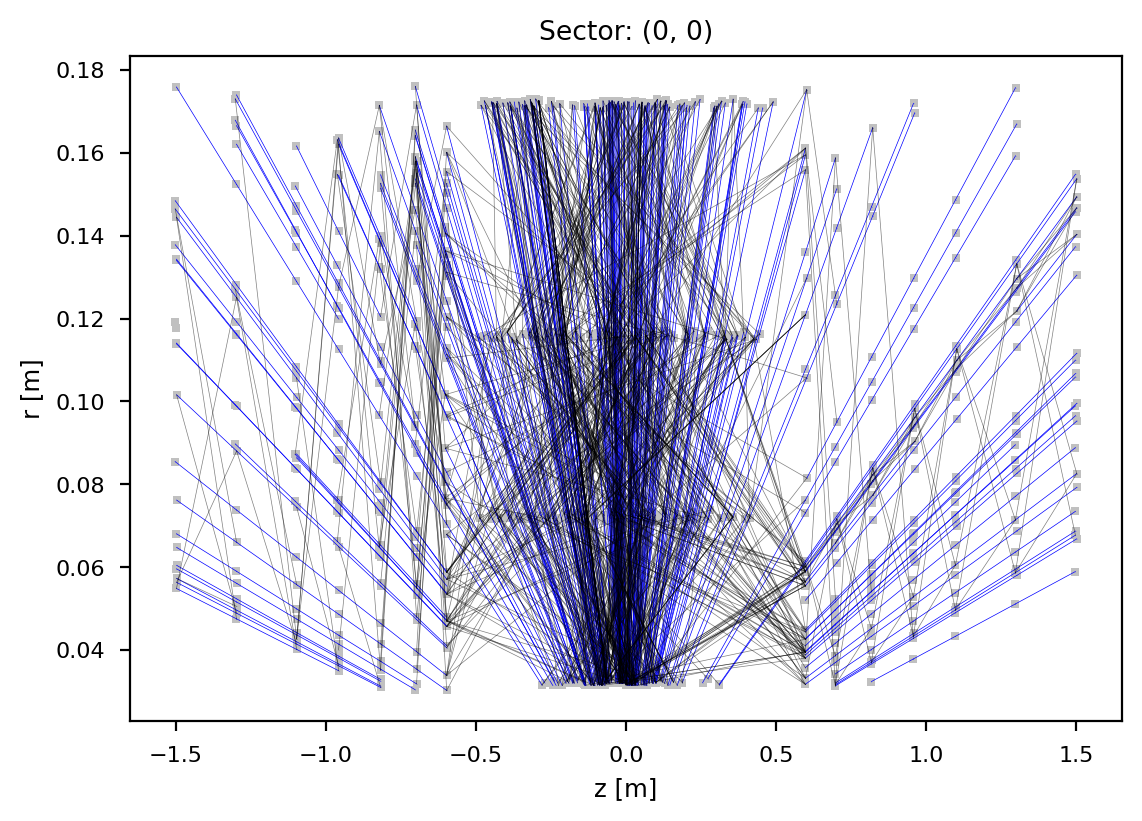

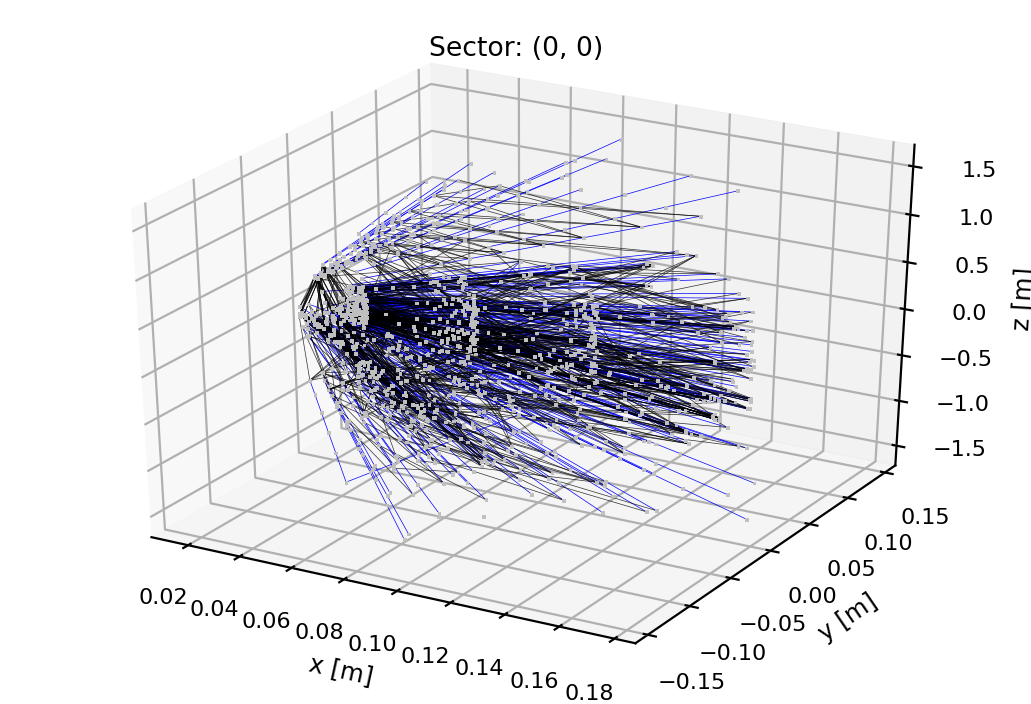

In [26]:
for sector in graph_sectors[0]:
    plot_rz(sector['x'], sector['edge_index'], sector['y'], sector['s'])
    plot_3d(sector['x'], sector['edge_index'], sector['y'], sector['s'])